Unlike previous labs, you will NOT implement UMAP here; I found that UMAP is sensitive to the hyperparameters (e.g., initialization, learning rate, #negative samples) and don't want you to optimize them.

Instead, we consider an important problem in non-parametric dimensionality reduction methods. Unlike PCA, UMAP (and t-SNE, Isomap, ...) constructs a low-dimensional embedding (say u) of high-dimensional data (say x) WITHOUT finding the exlicit map f: x -> u. Hence, even if UMAP can effectively find embeddings for currently given data, it cannot efficiently find an embedding for new data (given embeddings for the previous data).

In this lab, you will try to find "an efficient way" to find embeddings for new data.

In [1]:
!pip install umap-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import umap
import seaborn as sns

# We will use MNIST data
(X_train_, Y_train_), (X_test_, Y_test_) = mnist.load_data()
X_train_ = X_train_.reshape(X_train_.shape[0], -1) / 255
X_test_ = X_test_.reshape(X_test_.shape[0], -1) / 255

/Users/daehyuncho/anaconda3/envs/vis/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/daehyuncho/anaconda3/envs/vis/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/daehyuncho/anaconda3/envs/vis/lib/python3.10/site-packages/

In [3]:
def my_sampler(X, Y, p):
  idx = np.full(len(Y), False, dtype=bool)
  for i in range(10):
    idx = idx | (Y == i)
  r = np.random.choice(a=[True, False], size=X.shape[0], p=[p, 1 - p])
  idx = idx & r
  return X[idx], Y[idx]

In [4]:
# To reduce the running time of UMAP, I subsampled approximately half of data
# You can freely choose another rate 'p' in between zero and one
X_train, Y_train = my_sampler(X_train_, Y_train_, p=0.5)
X_test, Y_test = my_sampler(X_test_, Y_test_, p=0.5)

n_train = X_train.shape[0]
n_test = X_test.shape[0]

print("number of training samples: {}, number of test samples: {}".format(n_train, n_test))

number of training samples: 29985, number of test samples: 4966


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


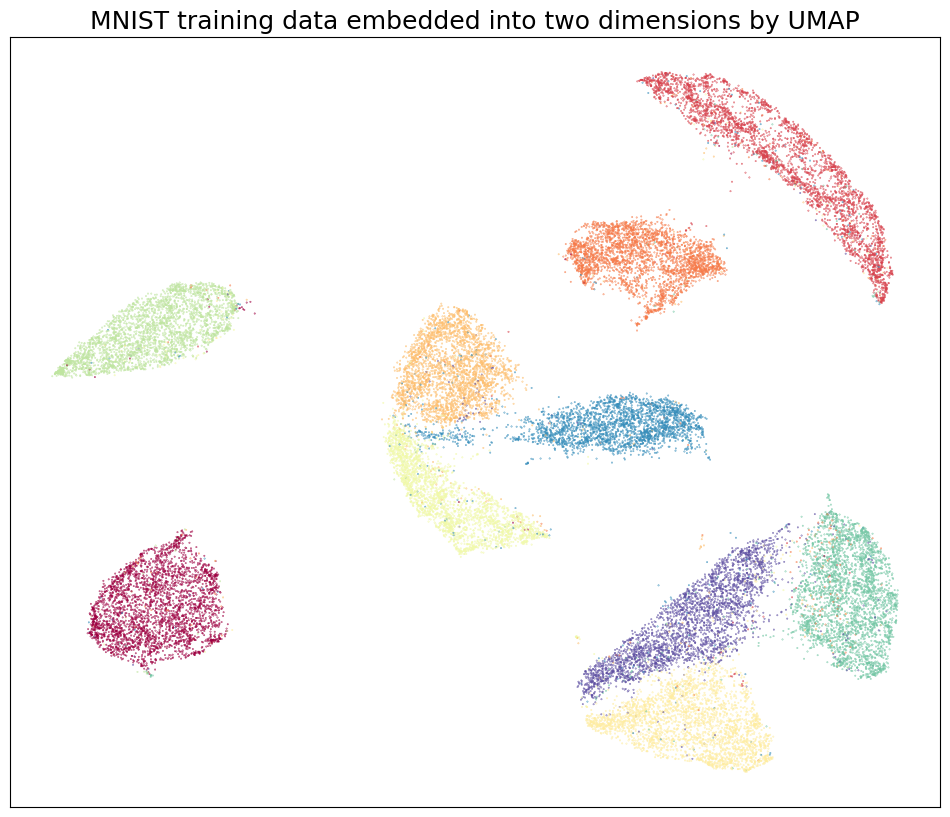

In [5]:
# Here we learn 2-dimensional embedding of the training data via UMAP
reducer = umap.UMAP(random_state=42)
embedding_train = reducer.fit_transform(X_train)

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=Y_train, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST training data embedded into two dimensions by UMAP", fontsize=18)

plt.show()

In [6]:
# Here, we compute the 2-dimensional embedding for the test data using the
# original training/test data and training data embedding

# Specifically, we do the following procedure
# - For each test data, find its k-NN training data in the data space
# - Compute the embedding of the test data as an average of embeddings of
#   corresponding k-NN training data

# Note that I did not optimize 'k' here

from scipy.spatial.distance import cdist
k = 20

D = cdist(X_test, X_train)

n_test = len(X_test)
embedding_test = np.zeros([n_test, 2])

idx = np.argsort(D, axis=1)
idx = idx[:, :k]
for i in range(n_test):
  temp = embedding_train[idx[i]].mean(axis=0)
  embedding_test[i] = temp

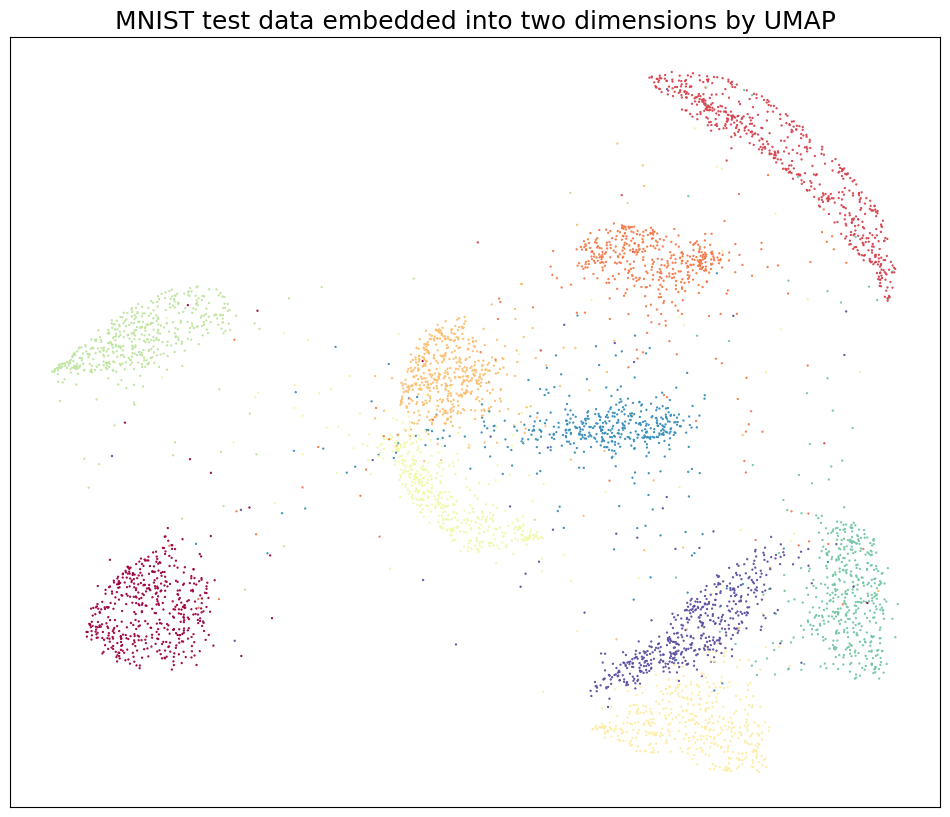

In [7]:
# Our simple procedure provides a reasonable embedding, but it is a bit noisy
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding_test[:, 0], embedding_test[:, 1], c=Y_test, cmap="Spectral", s=0.4)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST test data embedded into two dimensions by UMAP", fontsize=18)

plt.show()

From here, try to find a better embedding for the test data. Here, your embedding should not use the label information as in my implementation. Any "reasonable" approach improving mine will get the maximum point.

In [8]:
"""TODO: write you implementation for test data embedding here"""

k = 20

D = cdist(X_test, X_train)

n_test = len(X_test)
embedding_test = np.zeros([n_test, 2])

idx = np.argsort(D, axis=1)
idx = idx[:, :k]
for i in range(n_test):
  dists = D[i][idx[i]]

  w = np.repeat(dists, k).reshape(k, k).T
  np.fill_diagonal(w, 0)
  w = np.sum(w, axis=1)
  w = w / np.sum(w)
  
  temp = w @ embedding_train[idx[i]]
  embedding_test[i] = temp

In [9]:
"""TODO: write you implementation for test data embedding here"""

k = 20
n_boots = 10
leave = 4

D = cdist(X_test, X_train)

n_test = len(X_test)
embedding_test = np.zeros([n_test, 2])

idx = np.argsort(D, axis=1)
idx = idx[:, :k]
for i in range(n_test):
  cents = []
  for n in range(n_boots):
    _idx = np.random.choice(idx[i], size=k-leave)
    dists = D[i][_idx]
    w = np.repeat(dists, k-leave).reshape(k-leave, k-leave).T
    np.fill_diagonal(w, 0)
    w = np.sum(w, axis=1)
    w = w / np.sum(w)
    temp = w @ embedding_train[_idx]
  cents.append(temp)
  cents = np.mean(cents, axis=0)
  embedding_test[i] = cents

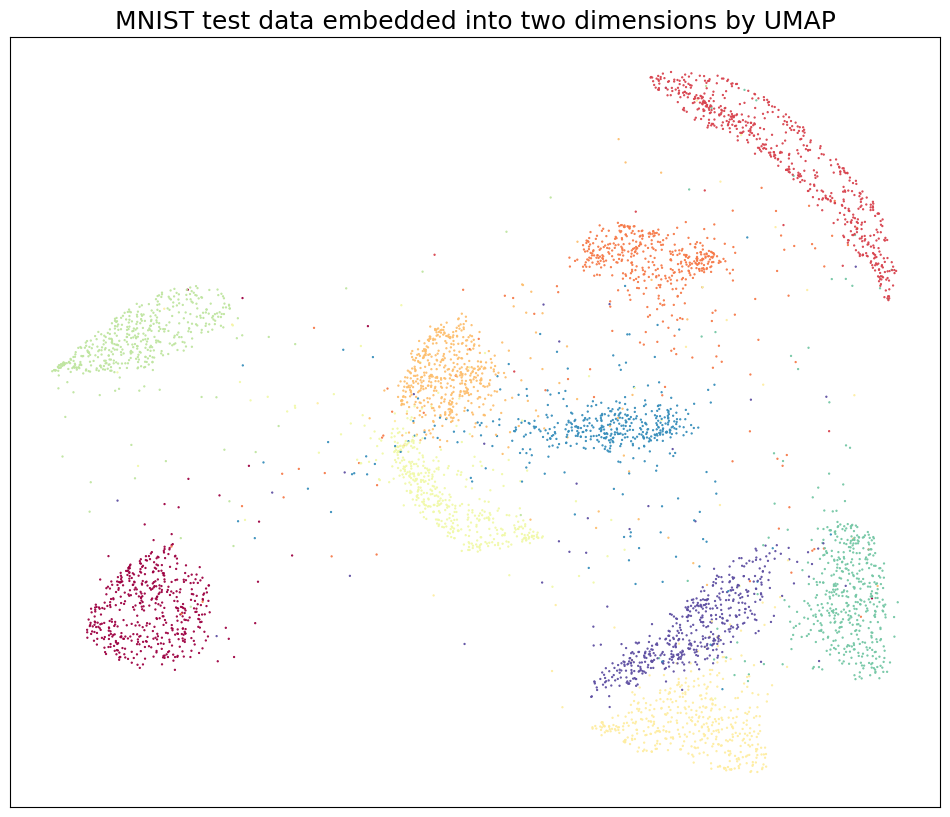

In [10]:
"""TODO: visualize your test data embedding here"""
# Our simple procedure provides a reasonable embedding, but it is a bit noisy
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding_test[:, 0], embedding_test[:, 1], c=Y_test, cmap="Spectral", s=0.4)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST test data embedded into two dimensions by UMAP", fontsize=18)

plt.show()

TODO: describe your algorithm and the intuition behind it here

Since points located near the center of a certain labels may be well locate again in the lower-dimensional embeddings through k-NN method. However points outside the clusters may find hard time locating themselves near the clusters. This is due to k-NN approach is susceptible to ouliters.

Therefore, with sampled k-nearest neighbours, I chose to leave some out and calculate the centroids in the lower dimension embeddings. (e.g. with 20 nearest neighbors, let's say I will remove 4 neighbors and calculate the neighbors and get a lower dimension embedding). Since leaving some points out may produce bad embeddings for point that are not in the clusters but rather on the closer boundary, I decided to repeat this calculating centroids just like bootstrapping.

Moreover, when calculating the centroids, rather than using simple average method, centroids weighted average based on the distance.

I could detect some points being more closer to the centroids.